In [2]:
# Cargando librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

In [3]:
# Cargando dataset
df = pd.read_excel("imdb_anime.xlsx")

In [4]:
# Analizando dataset
print("Dimensiones iniciales:", df.shape)
print("\nValores nulos por columna:\n", df.isnull().sum())
print("\nTipos de datos:\n", df.dtypes)

Dimensiones iniciales: (45717, 13)

Valores nulos por columna:
 Title                  0
Genre                  0
User Rating        20708
Number of Votes    20708
Runtime            13168
Year                 126
Summary            22170
Stars              32041
Certificate        17023
Metascore          45376
Gross              20708
Episode                0
Episode Title      10807
dtype: int64

Tipos de datos:
 Title              object
Genre              object
User Rating        object
Number of Votes    object
Runtime            object
Year               object
Summary            object
Stars              object
Certificate        object
Metascore          object
Gross              object
Episode            object
Episode Title      object
dtype: object


In [5]:
# Eliminando columnas poco utiles
df = df.drop(columns=["Summary", "Stars", "Episode Title"], errors="ignore")

In [ ]:
# Transformacion inicial de los datos

In [8]:
# Convertiendo user rating a numerico
df["User Rating"] = pd.to_numeric(df["User Rating"], errors="coerce")

# Number of Votes 
df["Number of Votes"] = df["Number of Votes"].replace({',':''}, regex=True)
df["Number of Votes"] = pd.to_numeric(df["Number of Votes"], errors="coerce")

# Runtime (extraer minutos)
df["Runtime"] = df["Runtime"].str.replace(" min","", regex=False)
df["Runtime"] = pd.to_numeric(df["Runtime"], errors="coerce")

# Año → numérico
df["Year"] = pd.to_numeric(df["Year"].astype(str).str[:4], errors="coerce")

# Metascore y Gross → numéricos
df["Metascore"] = pd.to_numeric(df["Metascore"], errors="coerce")
df["Gross"] = df["Gross"].replace({',':'', '\$':''}, regex=True)
df["Gross"] = pd.to_numeric(df["Gross"], errors="coerce")

<>:17: SyntaxWarning: invalid escape sequence '\$'
<>:17: SyntaxWarning: invalid escape sequence '\$'
C:\Users\daclv\AppData\Local\Temp\ipykernel_22868\3137291875.py:17: SyntaxWarning: invalid escape sequence '\$'
  df["Gross"] = df["Gross"].replace({',':'', '\$':''}, regex=True)


In [9]:
# Revisando outliers
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    return data[(data[column] < lower) | (data[column] > upper)]

numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} outliers")

User Rating: 822 outliers
Number of Votes: 3670 outliers
Runtime: 8864 outliers
Year: 389 outliers
Metascore: 9 outliers
Gross: 3670 outliers


In [11]:
# Transformando otras variables
# Categorizando variable genre
if "Genre" in df.columns:
    genre_dummies = df['Genre'].str.get_dummies(sep=',')
    df = pd.concat([df, genre_dummies], axis=1)
    df = df.drop(columns=["Genre"])

# Certificado como categórica
if "Certificate" in df.columns:
    df = pd.get_dummies(df, columns=["Certificate"], drop_first=True)

In [12]:
# Manejo de valores nulos: rellenar con la mediana en variables numéricas
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

In [13]:
# Creación de nuevas variables
df["Votes_per_Year"] = df["Number of Votes"] / (2025 - df["Year"] + 1)
df["Gross_per_Runtime"] = df["Gross"] / df["Runtime"]

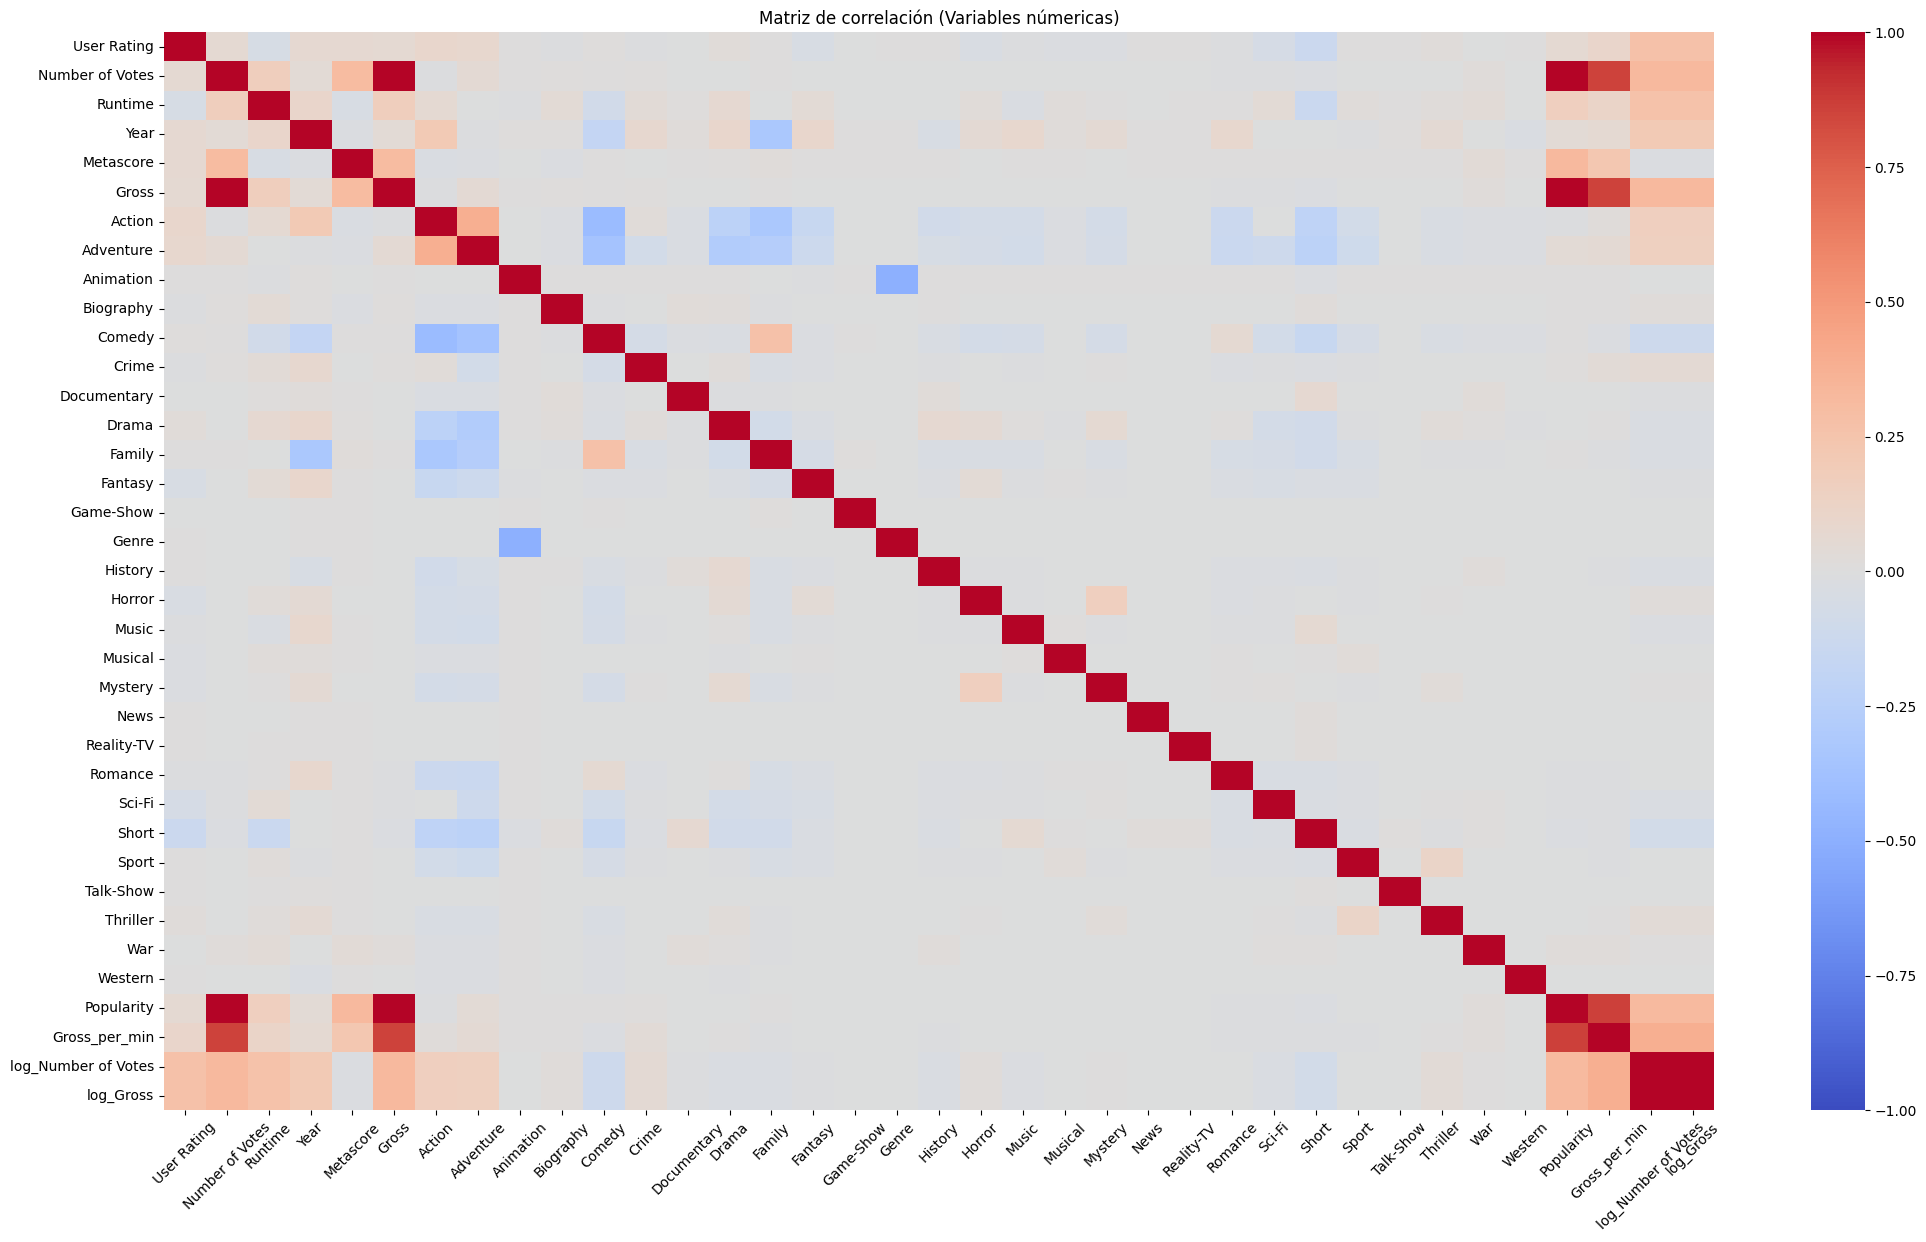


Correlaciones con User Rating:
 User Rating            1.000000
log_Number of Votes    0.267636
log_Gross              0.267636
Gross_per_min          0.100381
Action                 0.087159
Adventure              0.083655
Metascore              0.064625
Year                   0.063590
Popularity             0.062112
Number of Votes        0.056938
Gross                  0.056938
Drama                  0.030522
Thriller               0.016674
Comedy                 0.008230
History                0.007609
Family                 0.003808
Western                0.001191
Sport                  0.001126
Animation              0.001013
Talk-Show              0.000486
Genre                  0.000281
News                   0.000281
Reality-TV             0.000281
Documentary           -0.000419
Game-Show             -0.001829
War                   -0.005856
Crime                 -0.009520
Biography             -0.010652
Romance               -0.010656
Music                 -0.015438
Mystery

In [39]:
# Analisis de correlaciones
numeric_df = df.select_dtypes(include=[np.number]) 

plt.figure(figsize=(25,14))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=False)
plt.xticks(rotation=45)
plt.title("Matriz de correlación (Variables númericas)")
plt.show()

print("\nCorrelaciones con User Rating:\n", numeric_df.corr()["User Rating"].sort_values(ascending=False))

In [26]:
# Realizando funciones de procesamiento
def preprocess_dataset(path):
    data = pd.read_excel(path)

    # Eliminaciones
    data = data.drop(columns=["Summary", "Stars", "Episode Title"], errors="ignore")

    # Transformaciones
    data["User Rating"] = pd.to_numeric(data["User Rating"], errors="coerce")
    data["Number of Votes"] = data["Number of Votes"].replace({',':''}, regex=True)
    data["Number of Votes"] = pd.to_numeric(data["Number of Votes"], errors="coerce")
    data["Runtime"] = data["Runtime"].str.replace(" min","", regex=False)
    data["Runtime"] = pd.to_numeric(data["Runtime"], errors="coerce")
    data["Year"] = pd.to_numeric(data["Year"].astype(str).str[:4], errors="coerce")
    data["Metascore"] = pd.to_numeric(data["Metascore"], errors="coerce")
    data["Gross"] = data["Gross"].replace({',':'', '\$':''}, regex=True)
    data["Gross"] = pd.to_numeric(data["Gross"], errors="coerce")

    # Dummies
    if "Genre" in data.columns:
        genre_dummies = data['Genre'].str.get_dummies(sep=',')
        data = pd.concat([data, genre_dummies], axis=1)
        data = data.drop(columns=["Genre"])
    if "Certificate" in data.columns:
        data = pd.get_dummies(data, columns=["Certificate"], drop_first=True)

    # Nulos
    for col in data.select_dtypes(include=np.number).columns:
        data[col] = data[col].fillna(data[col].median())

    # Nuevas variables
    data["Votes_per_Year"] = data["Number of Votes"] / (2025 - data["Year"] + 1)
    data["Gross_per_Runtime"] = data["Gross"] / data["Runtime"]

    return data

df_processed = preprocess_dataset("imdb_anime.xlsx")
print("\nDataset final procesado:", df_processed.shape)


<>:16: SyntaxWarning: invalid escape sequence '\$'
<>:16: SyntaxWarning: invalid escape sequence '\$'
C:\Users\daclv\AppData\Local\Temp\ipykernel_22868\2484636661.py:16: SyntaxWarning: invalid escape sequence '\$'
  data["Gross"] = data["Gross"].replace({',':'', '\$':''}, regex=True)



Dataset final procesado: (45717, 77)


In [29]:
# Seleccionando variables
X = df_processed.drop(columns=["User Rating"])
y = df_processed["User Rating"]

# Filtrar solo columnas numéricas en X
X_numeric = X.select_dtypes(include=[np.number])

# Método de correlación 
correlations = X_numeric.corrwith(y).abs().sort_values(ascending=False)

# Forward Selection
model = LinearRegression()
sfs = SequentialFeatureSelector(model, n_features_to_select=5, direction='forward')
sfs.fit(X_numeric.fillna(0), y.fillna(0))

selected_features = X_numeric.columns[sfs.get_support()]

print("\nTop variables por correlación:\n", correlations.head(10))
print("\nVariables seleccionadas por Forward Selection:\n", selected_features)


Top variables por correlación:
  Short               0.127667
Gross_per_Runtime    0.100964
 Action              0.088528
 Adventure           0.083561
Metascore            0.064625
 Sci-Fi              0.057960
Votes_per_Year       0.056941
Number of Votes      0.056938
Gross                0.056938
Runtime              0.051081
dtype: float64

Variables seleccionadas por Forward Selection:
 Index(['Metascore', ' Action', ' Musical', ' Sci-Fi', ' Short'], dtype='object')


# Conclusiones:

## - Los dos métodos coinciden parcialmente: identifican Metascore y géneros específicos (Action, Short) como relevantes.
## - Forward Selection es más selectivo y orientado al modelo eligiendo un conjunto más pequeño de variables.
## - Las variables de genero y el Metascore influyen en la clasificación pero dependerá del método de selección.